## Flowers Recognition 

The Oxford Flowers 102 dataset is a collection of 102 flower categories commonly occurring in the United 
Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light 
variations. In addition, there are categories that have large variations within the category and several very 
similar categories. 
The dataset is divided into a training set, a validation set and a test set. The training set and validation set 
each consist of 10 images per class (a total of 1020 images each). The test set consists of the remaining 
6149 images (minimum 20 per class). Some tasks to consider: 
1. Modify some previously published architectures e.g., increase the network depth, reducing their 
parameters,  etc.  Explore  more  advanced  techniques  such  as  deformable  convolution,  dilated 
convolution (dilation>1) or visual prompt tuning for Transformers. 
2. Analyze the results of using fewer training images, i.e., few-shot learning 
3. Use  more  advanced  transformation  techniques  such  as  MixUp  (see  the  original  paper  and  its 
PyTorch implementation here) 
4. Try more advanced loss function such as triplet loss

## Purpose
This notebook is for experimenting with how base pre trained models handle the dataset without any modifications, before other improvements are made.

In [1]:
import platform

if platform.system() == "Darwin":  # macOS
    %pip install -r requirements_mac.txt
else:
    %pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Environment Setup

This section setups the environment by doing the following:
1. Importing the dependencies
2. Checking if CUDA/mps is available on device running this notebook
3. Setting up data and output folder to store downloaded dataset and outputs
4. Setting up of transforms for data augmentation
5. Downloading of datasets after transforms are initialized
6. Setting up of hyper parameters for training
7. Creation of dataloaders and visualizing data

### 1. Importing the dependencies

In [2]:
# Import necessary libraries
import os
import time
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import pandas as pd

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchsummary import summary  # For model architecture visualization

# Custom utility files
import src.data_utils as data_utils
import src.visualization as visualization

### 2. Checking if CUDA/mps is available

In [3]:
# Set the device based on availability of MPS (macOS), CUDA, or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 3. Setting up data and output folders to store downloaded dataset and output later on

In [4]:
# Define the data directories to store dataset and outputs
data_dir = "./data"
output_dir = "./output" 

# Create directories if they do not exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

### 4. Image Transforms and Augmentation
In the training transform, it is normalized to those values instead of (0.5, 0.5, 0.5) for both std and mean as it is common practice and was calculated based on millions of images. So we will try that for now.

Ref: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

In [5]:
data_transforms = data_utils.get_data_transforms()
display(data_transforms)

{'train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.2)
     RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.15, 0.15))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'val_test': Compose(
     Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

### 5. Dataset Downloading
- Load the Oxford Flowers 102 dataset which is split into the following:
  - Training : 10 image per class (1020 images)
  - Validation : 10 image per class (1020 images)
  - Test set : remaining images (6149 images)

In [6]:
# Download the dataset
flowers_dataset = data_utils.load_flowers102_dataset(data_dir)
display(flowers_dataset)

Train set size: 1020
Validation set size: 1020
Test set size: 6149


{'train': Dataset Flowers102
     Number of datapoints: 1020
     Root location: ./data
     split=train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.2)
                RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.15, 0.15))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset Flowers102
     Number of datapoints: 1020
     Root location: ./data
     split=val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                T

The actual labels were acquired from https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1.
We use this to map the actual label to the flower name for better visualisation rather than reading something as 'Flower 1' or 'Flower 27'

In [7]:
flower_labels = data_utils.get_flower_labels("flower_labels.txt")
# Convert the labels to a pandas DataFrame
flower_labels_df = pd.DataFrame(flower_labels, columns=["Flower Name"])
display(flower_labels_df)

,Flower Name
0,pink primrose
1,hard-leaved pocket orchid
2,canterbury bells
3,sweet pea
4,english marigold
...,...
97,mexican petunia
98,bromelia
99,blanket flower
100,trumpet creeper


### 6. Hyperparameters Setup

In [8]:
# Hyperparameters setup
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
AVAILABLE_MODELS = ['resnet50', 'vgg16', 'densenet121', 'baselineCNN', 'dilatedCNN']  # Add more models as needed
MODEL = AVAILABLE_MODELS[0] # Other options include 'vgg16', 'densenet121', etc.
NUM_CLASSES = 102 # Number of classes in the dataset, Oxford 102 has 102 classes

print(f"Selected model: {MODEL}") 

Selected model: resnet50


### 7. Creation of dataloaders and visualizing data

In [9]:
# Create our dataloaders for batching and iterators
data_loaders = data_utils.create_dataloaders(datasets_dict=flowers_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Store our dataset sizes in a dictionary for easy access
dataset_sizes = {
    'train': len(data_loaders['train'].dataset),
    'val': len(data_loaders['val'].dataset),
    'test': len(data_loaders['test'].dataset)
}
display(dataset_sizes)

{'train': 1020, 'val': 1020, 'test': 6149}

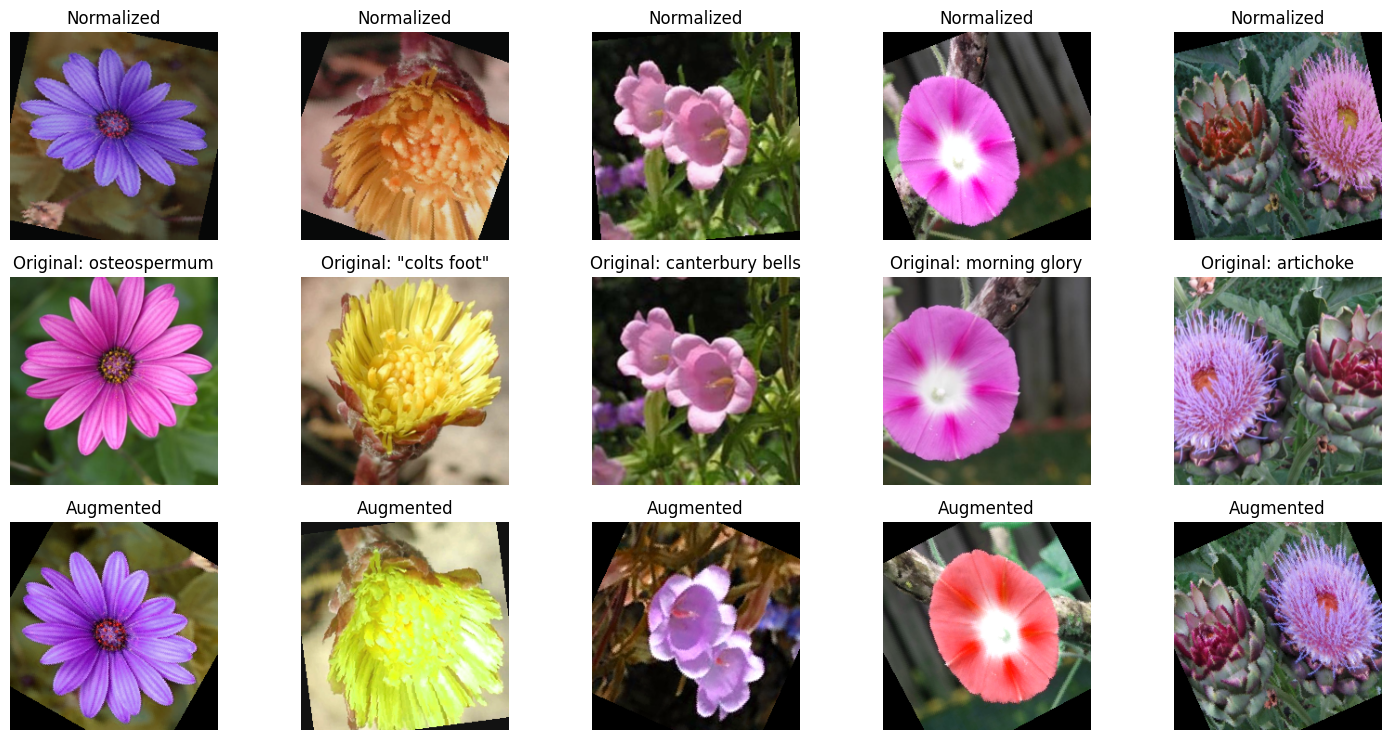

In [10]:
# Visualize a few samples from the training dataset
visualization.visualize_dataset_samples(flowers_dataset['train'], flower_labels, num_samples=5, show_augmented=True)

## Training and evaluating the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.


The `train_model` function is designed to train and evaluate a given neural network model over a specified number of epochs.

## Parameters:

- **model**: The neural network model to be trained.
- **criterion**: The loss function.
- **optimizer**: The optimization algorithm.
- **scheduler**: Adjusts the learning rate based on the number of epochs.
- **num_epochs**: Number of times the model will be trained over the entire dataset (default is 25).

## Process:

1. **Time Tracking**:
    - The start time is recorded to calculate the total training time at the end.

2. **Temporary Directory for Checkpoints**:
    - A temporary directory is created to save the best model parameters during training.

3. **Training Loop**:
    - For each epoch:
        - The model is trained on the training dataset and evaluated on the validation dataset.
        - Depending on the phase (`train` or `val`), the model is set to the appropriate mode using `model.train()` or `model.eval()`.
        - The gradients are zeroed out at the beginning of each batch using `optimizer.zero_grad()`.
        - The model's predictions are compared to the actual labels to compute the loss.
        - If in the training phase, backpropagation is performed and the optimizer updates the model's parameters.
        - Running statistics like loss and accuracy are computed for each epoch.
        - If in the training phase, the learning rate scheduler adjusts the learning rate.
        - The best model (based on validation accuracy) is saved to the temporary directory.

4. **Results**:
    - After all epochs are completed, the total training time is printed.
    - The best validation accuracy achieved during training is also printed.

5. **Load Best Model**:
    - The best model parameters saved during training are loaded back into the model.

6. **Return**:
    - The trained model with the best parameters is returned.

By using this function, one can easily train and evaluate a neural network model, ensuring that the best version of the model (in terms of validation accuracy) is retained.



In [11]:
def plot_training_history(history, save_path=None):
    """
    Plot training and validation loss and accuracy
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
def display_model_architecture(model, device):
    # Display model architecture summary
    print(f"\nModel Architecture: {MODEL}")
    if torch.cuda.is_available():
        summary(model, (3, 224, 224), device=device.type)
    else:
        print("CUDA not available for model summary visualization.")

In [12]:
from tempfile import TemporaryDirectory
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    """
    Train the model
    
    Args:
        model: The model to train
        criterion: Loss function
        optimizer: Optimizer for updating weights
        scheduler: Learning rate scheduler
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        dataset_sizes: Dictionary with sizes of 'train' and 'val' datasets
        num_epochs: Number of epochs to train
        
    Returns:
        model: Trained model with best weights
    """
    since = time.time()
    device = next(model.parameters()).device
    
    # Track training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 20)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store history
                if phase == 'train':
                    history['train_loss'].append(epoch_loss)
                    history['train_acc'].append(epoch_acc.item())
                else:
                    history['val_loss'].append(epoch_loss)
                    history['val_acc'].append(epoch_acc.item())
                    # Update scheduler based on validation loss
                    scheduler.step(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, history

In [13]:
def evaluate_model(model, criterion, data_loader):
    """
    Evaluate the model on the test set
    
    Args:
        model: The model to evaluate
        criterion: Loss function
        data_loader: DataLoader for the test dataset
        
    Returns:
        test_loss: The average loss on the test set
        test_acc: The accuracy on the test set
        all_preds: List of all predictions
        all_labels: List of all true labels
    """
    device = next(model.parameters()).device
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    # No gradient computation needed for evaluation
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels for further analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate test loss and accuracy
    dataset_size = len(data_loader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = running_corrects.float() / dataset_size
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

In [14]:
# Set up the model, optimizer and scheduler for training and evaluation
from src.models.base_pretrained_model import BasePretrainedModel
model = BasePretrainedModel(model_name=MODEL, device=device, num_classes=NUM_CLASSES)

criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
# Using SGD with momentum
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # Adam optimizer with weight decay
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
# Learning rate scheduler - reduce learning rate when validation loss plateaus
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                factor=0.1, patience=5)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, data_loaders, dataset_sizes, num_epochs=NUM_EPOCHS)


Epoch 1/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.6436 Acc: 0.0147


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.4490 Acc: 0.0892

Epoch 2/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.3542 Acc: 0.1069


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.1155 Acc: 0.2578

Epoch 3/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.9944 Acc: 0.3373


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.6679 Acc: 0.3951

Epoch 4/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.5788 Acc: 0.4990


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2374 Acc: 0.5490

Epoch 5/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.1589 Acc: 0.6108


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.8196 Acc: 0.6049

Epoch 6/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.7268 Acc: 0.6382


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.4216 Acc: 0.6598

Epoch 7/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.3429 Acc: 0.7235


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.1101 Acc: 0.7147

Epoch 8/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.9889 Acc: 0.7843


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.8118 Acc: 0.7480

Epoch 9/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.7315 Acc: 0.8176


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5668 Acc: 0.7794

Epoch 10/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.4496 Acc: 0.8431


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.3629 Acc: 0.8069

Epoch 11/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.2524 Acc: 0.8608


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.2419 Acc: 0.8137

Epoch 12/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.0377 Acc: 0.9069


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.0695 Acc: 0.8206

Epoch 13/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.9530 Acc: 0.8912


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9715 Acc: 0.8402

Epoch 14/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.7926 Acc: 0.9275


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9086 Acc: 0.8294

Epoch 15/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.6848 Acc: 0.9294


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8328 Acc: 0.8490

Epoch 16/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5941 Acc: 0.9529


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.7770 Acc: 0.8696

Epoch 17/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5151 Acc: 0.9539


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.7312 Acc: 0.8608

Epoch 18/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4703 Acc: 0.9637


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6656 Acc: 0.8804

Epoch 19/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4063 Acc: 0.9735


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6671 Acc: 0.8696

Epoch 20/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3840 Acc: 0.9667


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6070 Acc: 0.8814

Epoch 21/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3275 Acc: 0.9755


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5845 Acc: 0.8902

Epoch 22/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.2734 Acc: 0.9814


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5590 Acc: 0.8863

Epoch 23/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.2719 Acc: 0.9784


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5485 Acc: 0.8833

Epoch 24/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.2546 Acc: 0.9833


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5417 Acc: 0.8882

Epoch 25/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.2185 Acc: 0.9951


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5401 Acc: 0.8863

Training complete in 7m 19s
Best val Acc: 0.890196


C:\Users\J'sen\AppData\Local\Temp\ipykernel_20760\2288543375.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


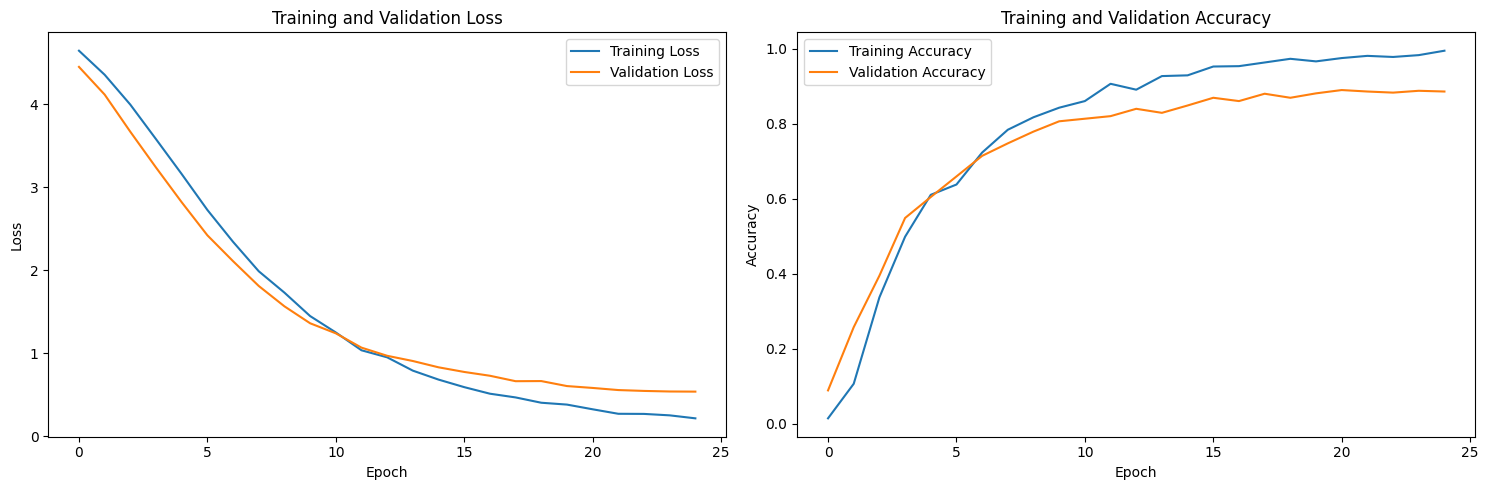

In [15]:
# Plot training history
plot_training_history(history)

In [16]:
# Evaluate the model on the test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {test_acc:.4f}")

# Calculate and print parameter count
total_params = sum(p.numel() for p in model.model.parameters())
trainable_params = sum(p.numel() for p in model.model.parameters() if p.requires_grad)

print(f"\nModel Parameter Information:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.6532 Acc: 0.8613
Final Test Accuracy: 0.8613

Model Parameter Information:
Total parameters: 23,717,030
Trainable parameters: 23,717,030
Non-trainable parameters: 0


Finding closest images for misclassification 1/5...
Finding closest images for misclassification 2/5...
Finding closest images for misclassification 3/5...
Finding closest images for misclassification 4/5...
Finding closest images for misclassification 5/5...


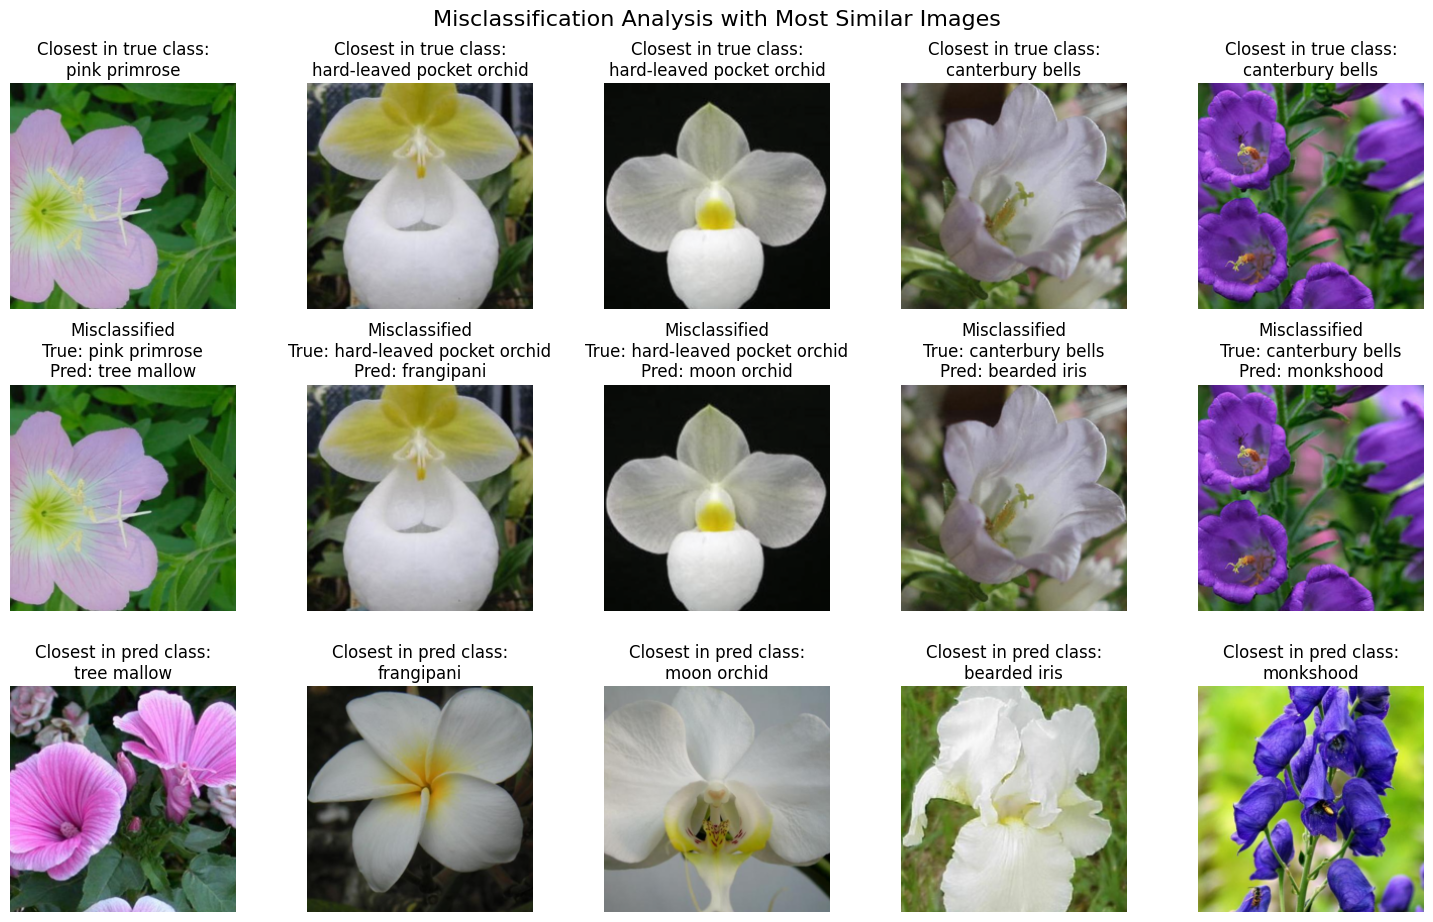

{'unique_true_classes': 3, 'unique_class_pairs': 5, 'total_examples': 5}

In [17]:
visualization.visualize_misclassifications_with_closest_images(model, data_loaders['test'], flower_labels, flowers_dataset['test'])

In [18]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, criterion, data_loaders['test'])


Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.6532 Acc: 0.8613


Random indices: [2006, 1828, 1143, 6033, 839], len(images): 6149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.6705182].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.6705182].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.3494118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.3494118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36904758..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36904758..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5589

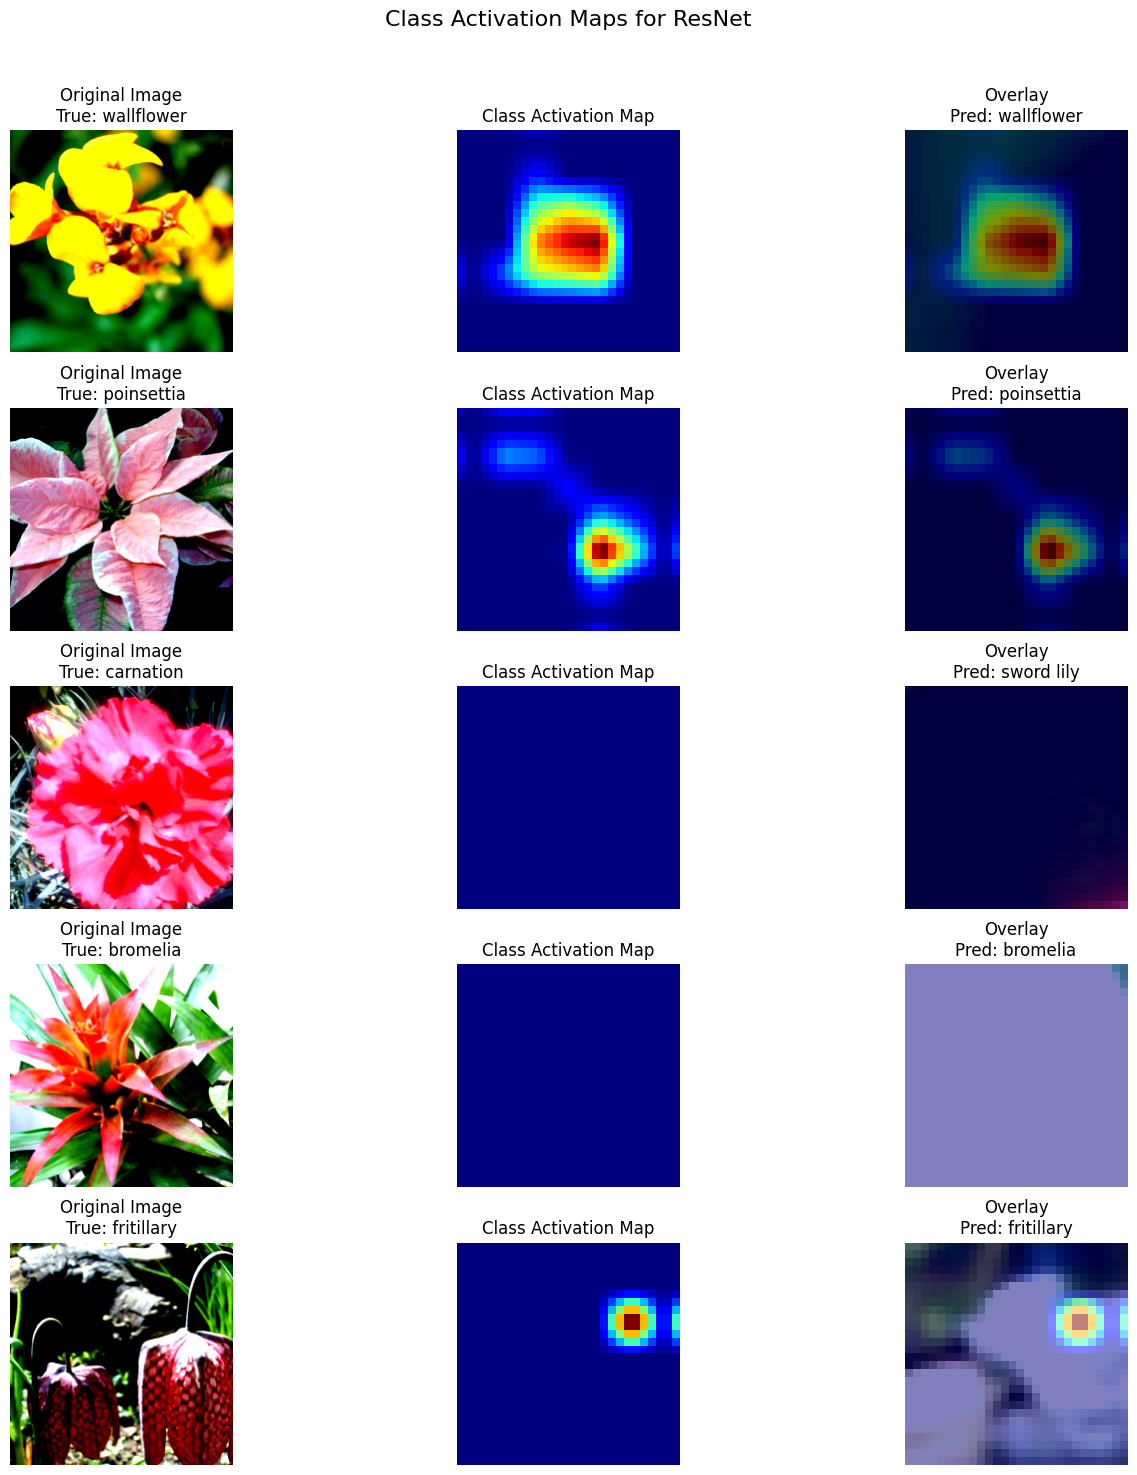

In [ ]:
visualization.show_cam(model.model, data_loaders['test'], device, flower_labels_df["Flower Name"])